## Image Embeddings

In [1]:
# We tried running ChromaDB in memory, but whenever we tried adding embedding into it, the kernel crashes.
# It's because of that, we chose to launch a ChromaDB container to do it.

In [2]:
#!pip install chromadb torch open-clip-torch

In [3]:
# Importing useful dependencies
import io
import os
import boto3
import torch
import chromadb
import open_clip
import numpy as np
from PIL import Image
from chromadb.config import Settings


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\SakuraSnow\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\SakuraSnow\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\SakuraSnow\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\

AttributeError: _ARRAY_API not found

In [4]:
# Setup S3 client for MinIO (MinIO implements Amazon S3 API)
s3 = boto3.client(
    "s3",
    endpoint_url="http://127.0.0.1:9000", # MinIO API endpoint
    aws_access_key_id="minioadmin", # User name
    aws_secret_access_key="minioadmin", # Password
)

In [5]:
# Connect to the server (Docker Container)
client = chromadb.HttpClient(host="localhost", port=8000)
# Although we set a path for persistent directory when defining the Docker Container
# It actually stores the embeddings inside the container

# We can use the following line to remove all the stored data in a collection
#client.delete_collection(name="images")

# Create or get the collection named "images"
collection = client.create_collection(name="images", get_or_create=True, embedding_function=None)

In [6]:
# Function that prints the embeddings stored in a collection
def print_stored_embeddings(collection, x=None): # x is the maximum number of files to print
    results = collection.get(include=["documents", "embeddings"])
    for i in range(len(results["documents"])):
        print("ID:", results['ids'][i])
        print("Document:", results["documents"][i])
        print("Embedding (first 5 dims):", results["embeddings"][i][:5])
        print("---")
        if x and (x-1) == i:
            break

# We can use this function to print the embeddings stored in chromaDB
print_stored_embeddings(collection, x = 10)

**Creating Embeddings**

Here we are going to generate, for each image stored in the Trusted Zone, a corresponding embedding and store it in the ChromaDB collection images. To achieve this, we select the ViT-B/16 model from OpenAI’s CLIP family as our pretrained embedding generator. Although ChromaDB provides an inherent embedding function, we choose not to use it in order to maintain full control over the embedding generation process.

In [7]:
# Just in case our device has gpu
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model + preprocessing
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-16", pretrained="openai")
model.to(device)

C:\Users\SakuraSnow\AppData\Local\Programs\Python\Python311\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [8]:
# The next function returns the embedding of the given PIL Image
def embed_image(preprocess, model, pil_img):
    img_tensor = preprocess(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        feats = model.encode_image(img_tensor)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats.cpu().numpy().squeeze()

In [9]:
# We can use this function to retrieve an image from our bucket in PIL Image format
def get_image(bucket, key):
    resp = s3.get_object(Bucket=bucket, Key=key)
    body = resp["Body"].read()
    img = Image.open(io.BytesIO(body))
    return img

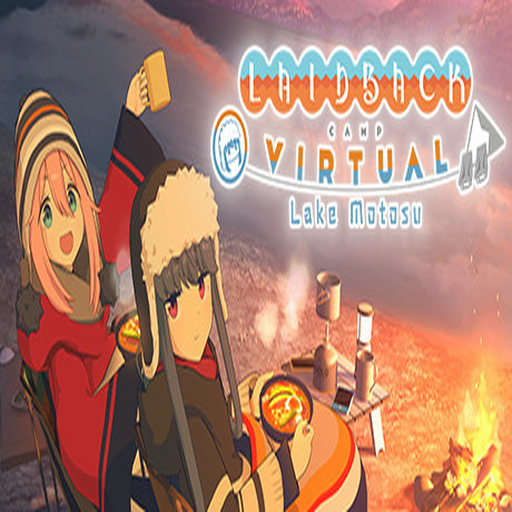

In [13]:
# Sample PIL Image
img_example = get_image("trusted-zone", "images/image_1760786279989.png")
img_example

In [14]:
# The embedding vector of the sample image
img_example_emb = embed_image(preprocess, model, img_example)
print(f"Embedding Vector (first 5 dims): {img_example_emb[:5]}")
print(f"Embedding Vector Size: {img_example_emb.size}")

Embedding Vector (first 5 dims): [ 0.02947029 -0.1140053   0.04303506 -0.00201758 -0.01612438]
Embedding Vector Size: 512


In [15]:
# The next function stores the embeddings of the images stored in the Trusted Zone and store them in the collection named 'images' of our ChromaDB
def images_to_embeddings(src_bucket, collection, preprocess, model, src_prefix=""):

    # Incremental id assigned to each image embedding
    id_counter = 0
    
    paginator = s3.get_paginator("list_objects_v2") # It returns objects in pages and not all at once.
    for page in paginator.paginate(Bucket=src_bucket, Prefix=src_prefix):

        # List of paths (meta_data)
        image_paths = []
        # List of embeddings
        embeddings = []
        # List of unique IDs for each embedding
        ids = []
        
        for obj in page.get("Contents", []):

            key = obj["Key"]

            if obj['Size'] == 0 and key.endswith("/"): # skip the folder itself
                continue

            id_counter += 1

            # Download the image
            img = get_image(src_bucket, key)
            
            # Compute embedding
            vector = embed_image(preprocess, model, img) # A numerical vector of size 512

            print(f"Created embedding for {key} ({len(embeddings)} items in current batch).")

            # Storing data
            image_paths.append(f"{src_bucket}/{key}")
            embeddings.append(vector)
            ids.append(f"img_{id_counter}")

        # Store the images of a page at once
        collection.add(
                ids=ids,
                documents=image_paths,
                embeddings=embeddings
        )

        print(f"All embeddings in the current batch are store successfully in the collection {collection.name}.")

In [16]:
# Store embeddings
images_to_embeddings(src_bucket = "trusted-zone", src_prefix = "images/", collection = collection, preprocess = preprocess, model = model)

Created embedding for images/image_1760786279860.png (0 items in current batch).
Created embedding for images/image_1760786279932.png (1 items in current batch).
Created embedding for images/image_1760786279989.png (2 items in current batch).
Created embedding for images/image_1760786280056.png (3 items in current batch).
Created embedding for images/image_1760786280131.png (4 items in current batch).
Created embedding for images/image_1760786280218.png (5 items in current batch).
Created embedding for images/image_1760786280278.png (6 items in current batch).
Created embedding for images/image_1760786280334.png (7 items in current batch).
Created embedding for images/image_1760786280394.png (8 items in current batch).
Created embedding for images/image_1760786280458.png (9 items in current batch).
Created embedding for images/image_1760786280522.png (10 items in current batch).
Created embedding for images/image_1760786280581.png (11 items in current batch).
Created embedding for imag

In [17]:
# Check the embeddings stored in chromaDB
print_stored_embeddings(collection)

ID: img_1
Document: trusted-zone/images/image_1760786279860.png
Embedding (first 5 dims): [ 0.05432418 -0.04641402  0.03838175 -0.03156456 -0.06540012]
---
ID: img_2
Document: trusted-zone/images/image_1760786279932.png
Embedding (first 5 dims): [ 0.06348297 -0.02147878  0.01417415  0.02201812 -0.06098729]
---
ID: img_3
Document: trusted-zone/images/image_1760786279989.png
Embedding (first 5 dims): [ 0.02947029 -0.11400531  0.04303506 -0.00201758 -0.01612437]
---
ID: img_4
Document: trusted-zone/images/image_1760786280056.png
Embedding (first 5 dims): [ 0.0493039  -0.04327977 -0.03419529  0.00995165  0.00029371]
---
ID: img_5
Document: trusted-zone/images/image_1760786280131.png
Embedding (first 5 dims): [ 0.06624919 -0.09444266 -0.00818789 -0.03171292 -0.00801206]
---
ID: img_6
Document: trusted-zone/images/image_1760786280218.png
Embedding (first 5 dims): [-0.0163     -0.04233447  0.05253831  0.00607723 -0.05615968]
---
ID: img_7
Document: trusted-zone/images/image_1760786280278.png
